In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [6]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
SEQUENCE_LENGTH = 60
pad_token = '<PAD>'
EMBEDDING_DIM = 300

In [7]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [9]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [10]:
testData = testData.loc[testData["polarity"] != 2]

In [11]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [13]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [14]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [15]:
# !wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [16]:
!unzip drive/MyDrive/glove.42B.300d.zip

Archive:  drive/MyDrive/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [17]:
def load_embeddings(filename):
    labels = []
    rows = []
    result = {}
    with open(filename, encoding='utf-8') as infile:
        for i, line in tqdm(enumerate(infile)):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
            result [items[0]] = values
    # arr = np.vstack(rows)
    return result 
    # return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('glove.42B.300d.txt')
# average = np.mean(vectors , axis = 0)

1917494it [03:38, 8767.66it/s]


In [18]:
average =  sum(embeddings.values()) / len(embeddings)

In [19]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"

In [20]:
def decode_sentiment(score):
  SENTIMENT_THRESHOLD = 0.5
  if score <= SENTIMENT_THRESHOLD:
      label = NEGATIVE
  elif score >= SENTIMENT_THRESHOLD:
      label = POSITIVE
  return label

In [21]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score )

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [22]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

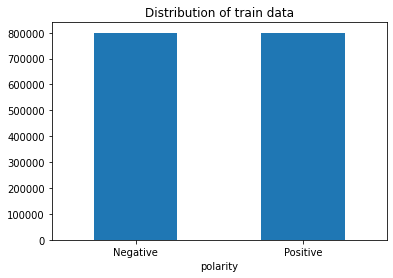

In [23]:
ax = trainData.groupby('polarity').count().plot(kind='bar', title='Distribution of train data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

[Text(0, 0, 'Negative'), Text(0, 0, 'Positive')]

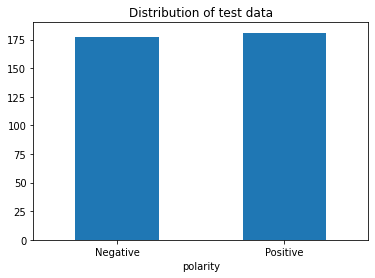

In [24]:
ax = testData.groupby('polarity').count().plot(kind='bar', title='Distribution of test data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [25]:
text, sentiment = list(trainData['text']), list(trainData['polarity'])

In [26]:
test_text, test_sentiment = list(testData['text']), list(testData['polarity'])

In [27]:
del trainData 
del testData

In [28]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 137 seconds


In [29]:
t = time.time()
processed_test_text = preprocess(test_text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 0 seconds


In [30]:
# del  test_text , text

In [31]:
maxLength = 0
for item in processedtext:
  if len(item.split()) > maxLength:
 
    maxLength = len(item.split())
print(f"maximum sequence length is: {maxLength} " )

maximum sequence length is: 52 


In [32]:
tokenizer = Tokenizer( )
tokenizer.fit_on_texts(processedtext)

In [33]:
vocab_size = len(tokenizer.word_index)
print("Total words", vocab_size)

Total words 249775


In [34]:
vocabulary =  tokenizer.word_index
print('Found %s unique tokens.' % len(vocabulary))

Found 249775 unique tokens.


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(pad_sequences(tokenizer.texts_to_sequences(processedtext), maxlen=SEQUENCE_LENGTH), sentiment ,test_size = 0.33, random_state = 42  )
print(f'Data Split done.')

Data Split done.


In [36]:
x_test = pad_sequences(tokenizer.texts_to_sequences(processed_test_text), maxlen=SEQUENCE_LENGTH)
y_test = test_sentiment

In [ ]:
# del processedtext , processed_test_text     , sentiment        , text                       

Word-Cloud for Negative tweets.

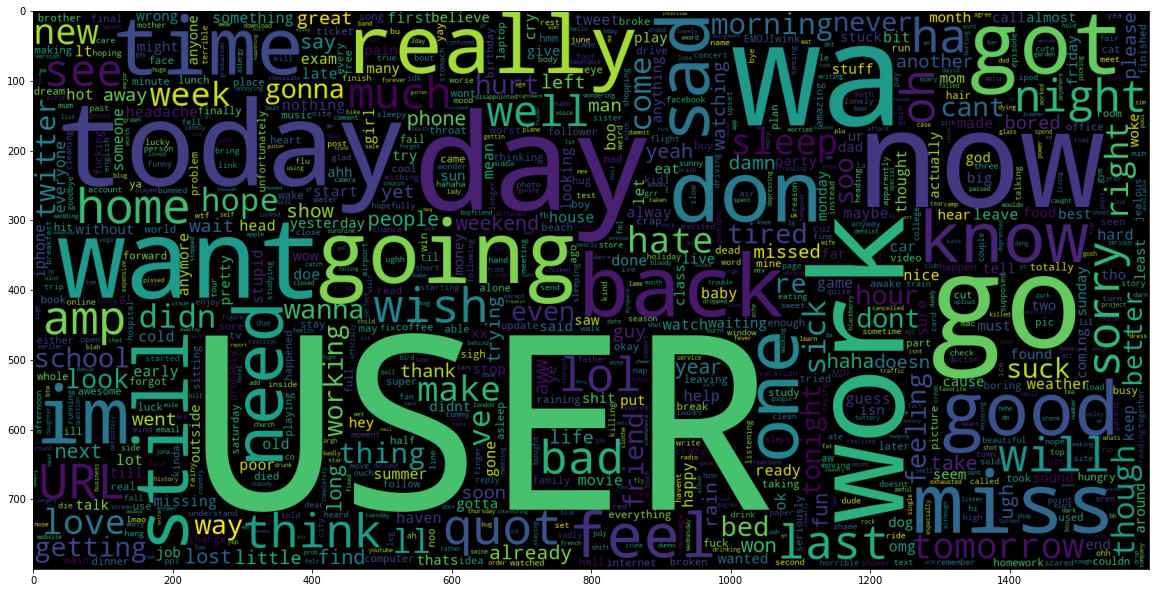

In [ ]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

Word-Cloud for Positive tweets.


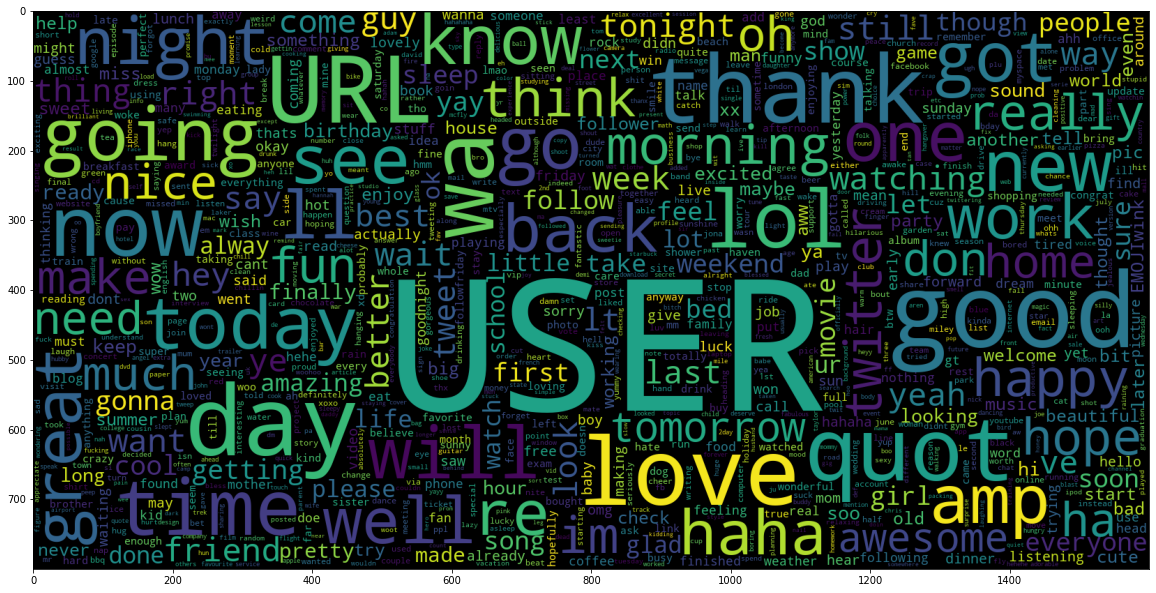

In [ ]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

 ## uni-directional LSTM

In [ ]:
embedding_matrix = np.zeros((len(vocabulary)+1 , EMBEDDING_DIM))

In [ ]:
for word, idx in vocabulary.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[idx] = embedding_vector
    else:
        embedding_matrix[idx] = average

In [ ]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = tf.keras.models.Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.LSTM(150, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.LSTM(150 , dropout = 0.2))
# model.add(tf.keras.layers.Dense(3, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]

model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
BATCH_SIZE = 1024
EPOCHS = 3

In [ ]:
history = model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/3
1047/1047 [==============================] - 167s 152ms/step - loss: 0.4685 - accuracy: 0.7745 - precision: 0.7770 - recall: 0.7692 - val_loss: 0.4133 - val_accuracy: 0.8108 - val_precision: 0.8216 - val_recall: 0.7952 - lr: 0.0100
Epoch 2/3
1047/1047 [==============================] - 158s 151ms/step - loss: 0.4434 - accuracy: 0.7913 - precision: 0.7938 - recall: 0.7865 - val_loss: 0.4101 - val_accuracy: 0.8115 - val_precision: 0.8301 - val_recall: 0.7846 - lr: 0.0100
Epoch 3/3
1047/1047 [==============================] - 159s 152ms/step - loss: 0.4369 - accuracy: 0.7950 - precision: 0.7974 - recall: 0.7902 - val_loss: 0.4130 - val_accuracy: 0.8112 - val_precision: 0.8477 - val_recall: 0.7600 - lr: 0.0100


In [ ]:
model.save('unidirectional_lstm.h5')

In [ ]:
score = model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 0s 11ms/step - loss: 0.3778 - accuracy: 0.8268 - precision: 0.8606 - recall: 0.7845
ACCURACY: 0.826815664768219
LOSS: 0.37775033712387085


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

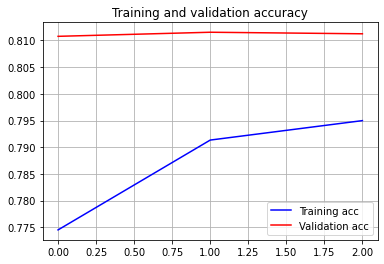

In [ ]:
plt.figure()
plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

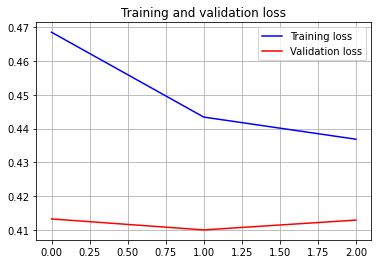

In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

12/12 [==============================] - 0s 7ms/step


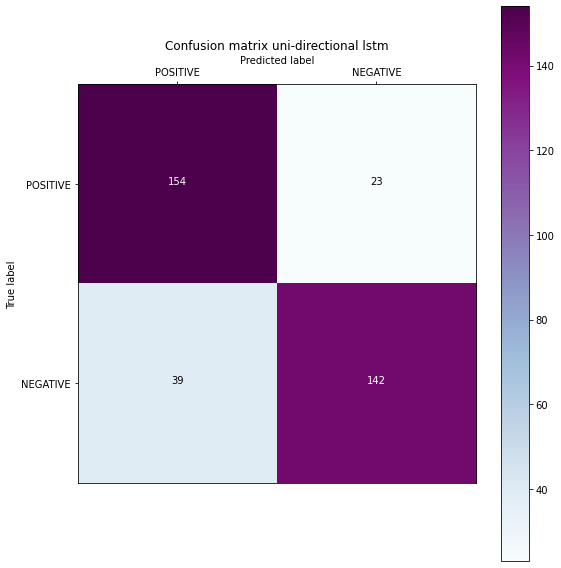

In [ ]:
y_pred_1d = []
y_test_1d = y_test
scores = model.predict(x_test, verbose=1)
# y_pred_1d = [decode_sentiment(score) for score in scores]
for score in scores:
  if score > 0.5:
    y_pred_1d.append(1)
  else:
    y_pred_1d.append(0)
cnf_matrix = tf.math.confusion_matrix(y_test_1d, y_pred_1d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix uni-directional lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test)):
  if y_pred_1d[i] == y_test_1d[i]:
    c+=1
print(c/len(y_test)*100)

82.68156424581005


## bidirectionalLSTM


In [ ]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy
embedding_layer = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
bi_model = tf.keras.models.Sequential()
bi_model.add(embedding_layer)
bi_model.add(tf.keras.layers.Dropout(0.5))
bi_model.add(   tf.keras.layers.Bidirectional (    tf.keras.layers.LSTM(150, dropout=0.2)) )
bi_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [ ]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 3
BATCH_SIZE = 1024
bi_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
history2 = bi_model.fit(X_train, np.array(Y_train),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data = (X_validation , np.array(Y_validation)),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/3
1047/1047 [==============================] - 316s 296ms/step - loss: 0.4698 - accuracy: 0.7735 - precision: 0.7763 - recall: 0.7675 - val_loss: 0.4164 - val_accuracy: 0.8101 - val_precision: 0.8320 - val_recall: 0.7782 - lr: 0.0100
Epoch 2/3
1047/1047 [==============================] - 311s 297ms/step - loss: 0.4405 - accuracy: 0.7927 - precision: 0.7948 - recall: 0.7884 - val_loss: 0.4089 - val_accuracy: 0.8137 - val_precision: 0.8388 - val_recall: 0.7777 - lr: 0.0100
Epoch 3/3
1047/1047 [==============================] - 308s 295ms/step - loss: 0.4354 - accuracy: 0.7962 - precision: 0.7981 - recall: 0.7922 - val_loss: 0.4053 - val_accuracy: 0.8165 - val_precision: 0.8288 - val_recall: 0.7990 - lr: 0.0100


In [ ]:
bi_model.save('bidirectional_lstm.h5')

In [ ]:
score = bi_model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 0s 17ms/step - loss: 0.3695 - accuracy: 0.8240 - precision: 0.8278 - recall: 0.8232
ACCURACY: 0.8240223526954651
LOSS: 0.36946702003479004


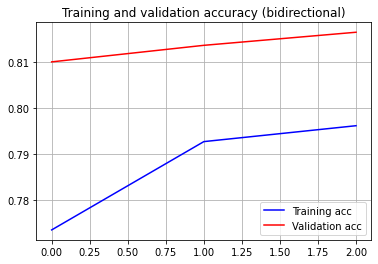

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


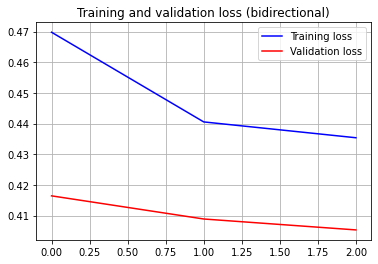

In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

12/12 [==============================] - 1s 12ms/step


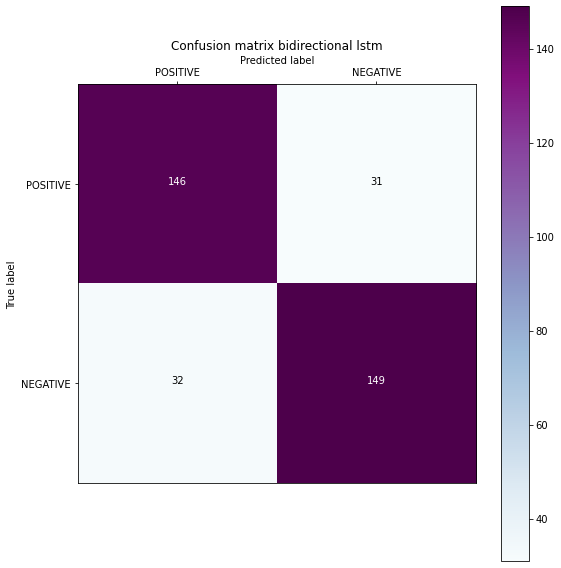

In [ ]:
y_pred_2d = []
y_test_2d = y_test
scores = bi_model.predict(x_test, verbose=1).round()
y_pred_2d = scores
# y_pred_1d = [decode_sentiment(score) for score in scores]
# for score in scores:
#   if score > 0.5:
#     y_pred_1d.append(1)
#   else:
#     y_pred_1d.append(0)
cnf_matrix = tf.math.confusion_matrix(y_test_2d, y_pred_2d)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix bidirectional lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test_2d)):
  if y_pred_2d[i] == y_test_2d[i]:
    c+=1
print(c/len(y_test_2d)*100)

82.40223463687151


##pyramidal LSTM

In [ ]:
adamoptimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
bceloss = tf.keras.losses.binary_crossentropy

In [ ]:
layer1 = {}
def LSTM_unit_1 (xin , i ):
    layer1['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_1_'+ str (i)) (xin)

In [ ]:
layer2 = {}
def LSTM_unit_2 (xin , i ):
    layer2['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_2_'+ str (i)) (xin)

In [ ]:
layer3 = {}
def LSTM_unit_3 (xin , i ):
    layer3['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_3_'+ str (i)) (xin)

In [ ]:
layer4 = {}
def LSTM_unit_4 (xin , i ):
    layer4['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= True , name = 'lstm_4_'+ str (i)) (xin)

In [ ]:
layer5 = {}
def LSTM_unit_5 (xin , i ):
    layer5['unit'+ str(i)] =  tf.keras.layers.LSTM(1, dropout=0.2 , return_sequences= False , name = 'lstm_5_'+ str (i)) (xin)

In [ ]:
inputsss = tf.keras.Input( shape = (  SEQUENCE_LENGTH) )
xin = Embedding(vocab_size +1,  300 , weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False) ( inputsss)

for i in range(64):
  LSTM_unit_1(xin , i+1)

In [ ]:
layer2_inputs = {}
for i in range(63):
  if i % 2 == 0 :
    layer2_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer1[f'unit{i+1}'] , layer1[f'unit{i+2}']  ] )

In [ ]:
layer2_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_1')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_2')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_3')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_4')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_5')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_6')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_7')>,
 9.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_8')>,
 10.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_9')>,
 11.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_10')>

In [ ]:
layer2 = {}
for i in range(32):
  LSTM_unit_2( layer2_inputs[i+1]  , i+1)

In [ ]:
layer2

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_16')>,
 'unit17': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_17')>,
 'unit18': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_2_18')>,
 'unit19': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm

In [ ]:
layer3_inputs = {}
for i in range(31):
  if i % 2 == 0 :
    layer3_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer2[f'unit{i+1}'] , layer2[f'unit{i+2}']  ] )

In [ ]:
layer3_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_32')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_33')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_34')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_35')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_36')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_37')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_38')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_39')>,
 9.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_40')>,
 10.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_41')>,
 11.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'conca

In [ ]:
layer3 = {}
for i in range(16):
  LSTM_unit_3( layer3_inputs[i+1]  , i+1)

In [ ]:
layer3

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_16')>,
 'unit2': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_2')>,
 'unit3': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_3')>,
 'unit4': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_3_4'

In [ ]:
layer4_inputs = {}
for i in range(16):
  if i % 2 == 0 :
    layer4_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer3[f'unit{i+1}'] , layer3[f'unit{i+2}']  ] )

In [ ]:
layer4 = {}
for i in range(16):
  LSTM_unit_4( layer3_inputs[i+1]  , i+1)

In [ ]:
layer4

{'unit1': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_1')>,
 'unit10': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_10')>,
 'unit11': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_11')>,
 'unit12': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_12')>,
 'unit13': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_13')>,
 'unit14': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_14')>,
 'unit15': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_15')>,
 'unit16': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_16')>,
 'unit2': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_2')>,
 'unit3': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_3')>,
 'unit4': <KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'lstm_4_4'

In [ ]:
layer5_inputs = {}
for i in range(16):
  if i % 2 == 0 :
    layer5_inputs[i/2+1] =  tf.keras.layers.Concatenate(  axis= -1)([  layer4[f'unit{i+1}'] , layer4[f'unit{i+2}']  ] )

In [ ]:
layer5_inputs

{1.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_56')>,
 2.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_57')>,
 3.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_58')>,
 4.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_59')>,
 5.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_60')>,
 6.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_61')>,
 7.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_62')>,
 8.0: <KerasTensor: shape=(None, 60, 2) dtype=float32 (created by layer 'concatenate_63')>}

In [ ]:
layer5 = {}
for i in range(8):
  LSTM_unit_5 (layer5_inputs[i+1] , i+1 )


In [ ]:
layer5

{'unit1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_1')>,
 'unit2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_2')>,
 'unit3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_3')>,
 'unit4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_4')>,
 'unit5': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_5')>,
 'unit6': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_6')>,
 'unit7': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_7')>,
 'unit8': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'lstm_5_8')>}

In [ ]:
lastInputs = []
for item , value in layer5.items():
  lastInputs.append(value)

In [ ]:
layer_5_concatenated =  tf.keras.layers.Concatenate(  axis= -1)( lastInputs )

In [ ]:
layer_5_concatenated

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'concatenate_64')>

In [ ]:
final_output = tf.keras.layers.Dense(1, activation='sigmoid') ( layer_5_concatenated)

In [ ]:
pyramid_model = tf.keras.Model(inputs=inputsss, outputs=final_output, name="pyramid_LSTM")

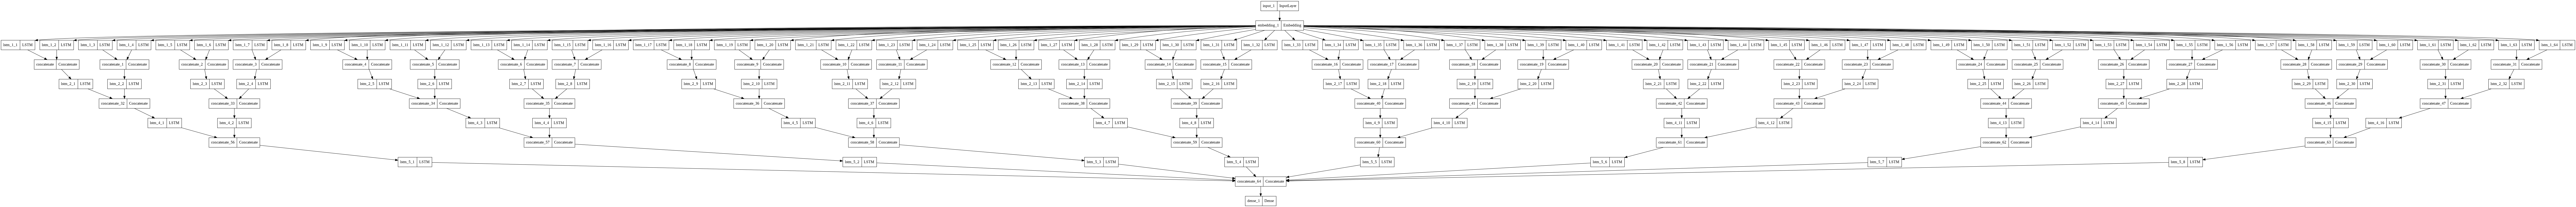

In [ ]:
tf.keras.utils.plot_model(pyramid_model)

In [ ]:
my_metrics =['accuracy' , 'Precision' , 'Recall'  ]
EPOCHS = 3
BATCH_SIZE = 2048
pyramid_model.compile( loss = bceloss , optimizer = adamoptimizer , metrics = my_metrics )

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=3, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
half = 1000
validSize = 1000

In [ ]:
history3 = pyramid_model.fit(X_train[:half], np.array(Y_train [ :half]),
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data = (X_validation[: validSize] , np.array(Y_validation [:validSize])),
                    verbose=1,
                    callbacks=callbacks  )

Epoch 1/10
1/1 [==============================] - 278s 278s/step - loss: 0.6946 - accuracy: 0.5070 - precision: 0.4972 - recall: 0.9078 - val_loss: 0.7013 - val_accuracy: 0.4960 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0100
Epoch 2/10
1/1 [==============================] - 4s 4s/step - loss: 0.6964 - accuracy: 0.5130 - precision: 1.0000 - recall: 0.0020 - val_loss: 0.6874 - val_accuracy: 0.5030 - val_precision: 1.0000 - val_recall: 0.0139 - lr: 0.0100
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6863 - accuracy: 0.5230 - precision: 1.0000 - recall: 0.0225 - val_loss: 0.6775 - val_accuracy: 0.6120 - val_precision: 0.6503 - val_recall: 0.4980 - lr: 0.0100
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.6787 - accuracy: 0.6150 - precision: 0.6388 - recall: 0.4857 - val_loss: 0.6731 - val_accuracy: 0.6380 - val_precision: 0.6006 - val_recall: 0.8413 - lr: 0.0100
Epoch 5/10
1/1 [==============================] - 4s 4s/step

In [ ]:
pyramid_model.save('pyramid_lstm.h5')

In [ ]:
score = pyramid_model.evaluate(x_test, np.array(y_test))
print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 11s 882ms/step - loss: 0.6135 - accuracy: 0.6844 - precision: 0.6977 - recall: 0.6630
ACCURACY: 0.6843575239181519
LOSS: 0.6135156750679016


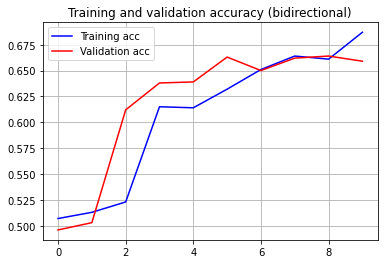

In [ ]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
 
epochs = range(len(acc))

plt.figure()

plt.grid() 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (bidirectional)')
plt.legend()
plt.show()


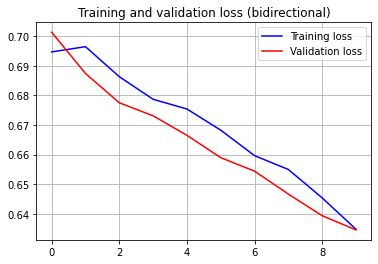

In [ ]:
plt.figure()
plt.grid() 

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (bidirectional)')
plt.legend()
plt.show()

12/12 [==============================] - 9s 810ms/step


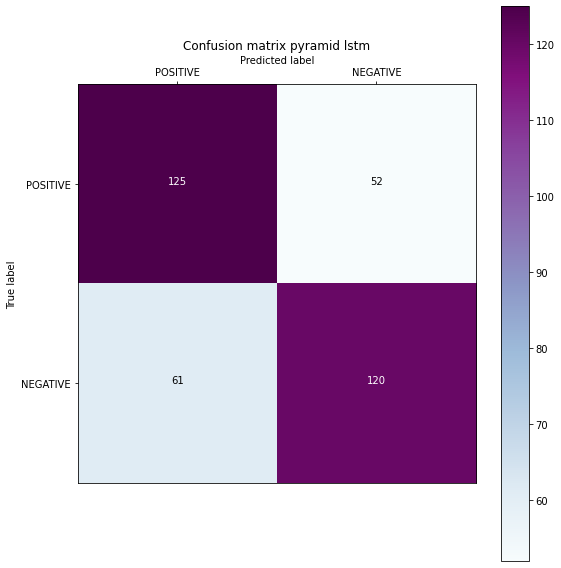

In [ ]:
y_pred_p = []
y_test_p = y_test
scores = pyramid_model.predict(x_test, verbose=1).round()
y_pred_p = scores
cnf_matrix = tf.math.confusion_matrix(y_test, y_pred_p)
plot_confusion_matrix(np.array(cnf_matrix), classes= [POSITIVE , NEGATIVE ], title="Confusion matrix pyramid lstm")
plt.show()

In [ ]:
c=0
for i in range(len(y_test)):
  if y_pred_p[i] == y_test[i]:
    c+=1
print(c/len(y_test)*100)

68.43575418994413


## fine tune BERT

In [1]:
!pip install -q -U tensorflow-text

In [2]:
pip install -q tf-models-official==2.4.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert
import pandas as pd
# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [5]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [6]:
!wget 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3?tf-hub-format=compressed'

--2022-01-09 11:20:06--  https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 172.217.203.101, 172.217.203.138, 172.217.203.102, ...
Connecting to tfhub.dev (tfhub.dev)|172.217.203.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_L-12_H-768_A-12/3.tar.gz [following]
--2022-01-09 11:20:06--  https://storage.googleapis.com/tfhub-modules/tensorflow/bert_en_uncased_L-12_H-768_A-12/3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.97.128, 142.251.107.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 408549353 (390M) [application/octet-stream]
Saving to: ‘3?tf-hub-format=compressed.3’

3?tf-hub-format=com 100%[===================>] 389.62M   192MB/s    in 2.0s    

2

In [7]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [8]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [9]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   return tokenizer.convert_tokens_to_ids(tokens)

In [10]:
s = "hello tensorflow!"

In [11]:
encode_sentence(s)

[7592, 23435, 12314, 999]

In [12]:
tokenizer.tokenize(s)

['hello', 'tensor', '##flow', '!']

In [13]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [14]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [15]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [16]:
testData = testData.loc[testData["polarity"] != 2]

In [17]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [18]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [19]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

In [20]:
testData.shape  , trainData.shape

((358, 2), (1599999, 2))

In [21]:
text, sentiment = list(trainData['text']), list(trainData['polarity'])

In [22]:
test_text, test_sentiment = list(testData['text']), list(testData['polarity'])

In [31]:
tokenized_text , tokenized_test_text =  tf.ragged.constant([ encode_sentence(s) for s in text ]) , tf.ragged.constant([ encode_sentence(s) for s in test_text ])

In [33]:
maxLength = 0
for item in test_text:
  if len(item.split()) > maxLength:
 
    maxLength = len(item.split())
print(f"maximum test sequence length is: {maxLength} " )

maximum test sequence length is: 30 


In [26]:
maxLength = 0
for item in text:
  if len(item.split()) > maxLength:
 
    maxLength = len(item.split())
print(f"maximum train sequence length is: {maxLength} " )

maximum train sequence length is: 64 


In [28]:
print("Sentence1 shape:", tokenized_text.shape.as_list())
print("Sentence2 shape:", tokenized_test_text.shape.as_list())

Sentence1 shape: [1599999, None]
Sentence2 shape: [358, None]


In [60]:
padded_train  = tokenized_text.to_tensor(shape = (1599999,70))

In [61]:
padded_test = tokenized_test_text.to_tensor(shape = (358,70))

In [62]:
padded_train.shape

TensorShape([1599999, 70])

In [63]:
padded_test.shape

TensorShape([358, 70])

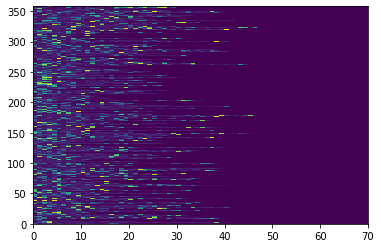

In [54]:
_ = plt.pcolormesh(tokenized_test_text.to_tensor(shape = (358 , 70)))

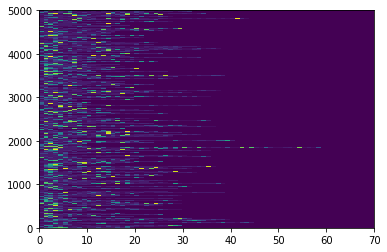

In [55]:
_ = plt.pcolormesh( padded_train [:5000])

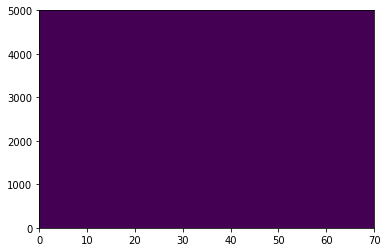

In [58]:
input_mask = tf.ones_like(padded_train)

plt.pcolormesh(input_mask[:5000])

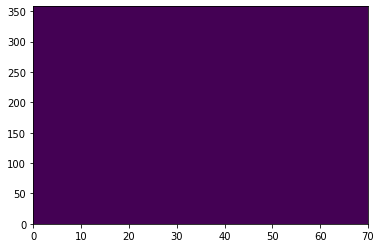

In [65]:
test_mask = tf.ones_like(padded_test)

plt.pcolormesh(test_mask)

In [35]:
train_text.shape

TensorShape([1599999, 228])

In [36]:
test_text.shape

TensorShape([1599999, 228])

In [ ]:
test_text[1]

In [41]:
test_sentiment[1]

1

In [42]:
sentiment [1000000]

1

In [50]:
test_sentiment_onehot = tf.keras.utils.to_categorical( test_sentiment, num_classes=2, dtype='float32')

In [51]:
sentiment_onehot = tf.keras.utils.to_categorical( sentiment, num_classes=2, dtype='float32')

In [52]:
sentiment_onehot.shape

(1599999, 2)

In [53]:
test_sentiment_onehot.shape

(358, 2)

In [68]:
input_mask = tf.ones_like(train_text)
type(input_mask)
# plt.pcolormesh(input_mask)

tensorflow.python.framework.ops.EagerTensor

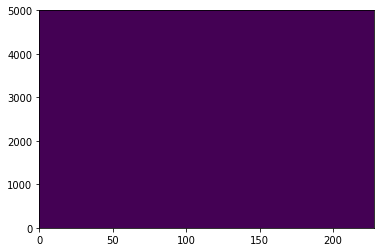

In [73]:
plt.pcolormesh(input_mask[150000:155000])


In [45]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [46]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

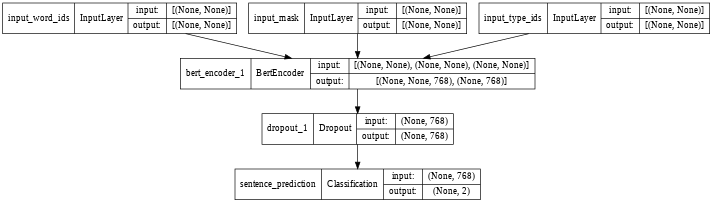

In [47]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)


In [65]:
# glue_batch = { key : val for key, val in  [ [1,2] , [3,4] , [5,6]] }

bert_classifier(  glue_batch , training=True ).numpy()

ValueError: ignored

In [64]:
glue_batch

{1: 2, 3: 4, 5: 6}

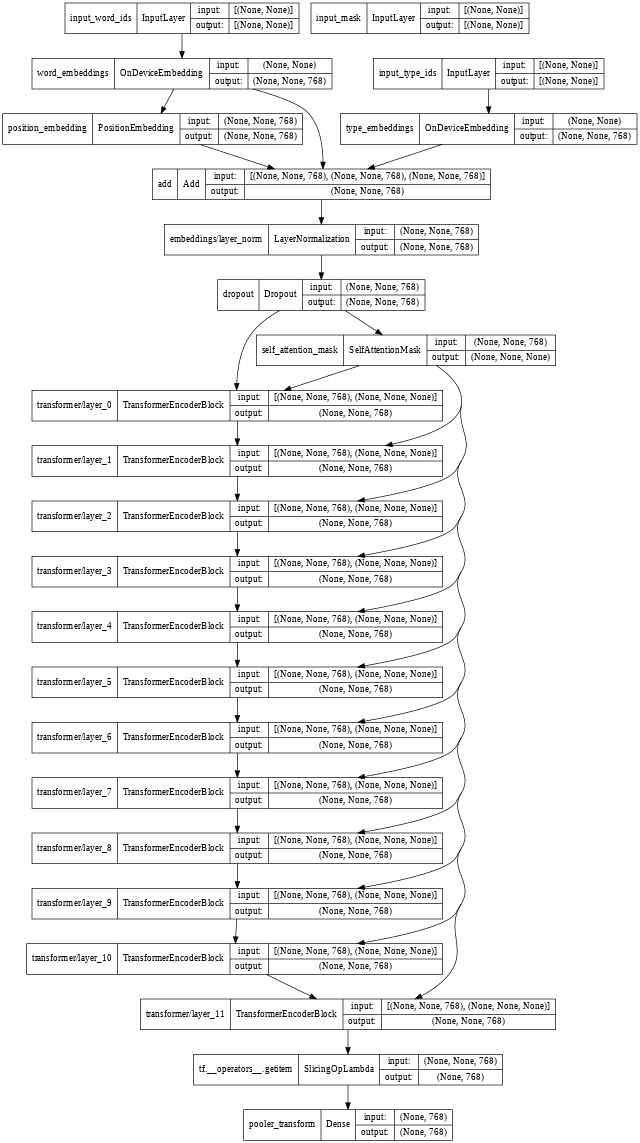

In [57]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)
